# COMP 2002 Intro to AI
## Assignment

This assignment contributes 70% of the overall module mark for COMP2002 and is an individual
assignment. You must submit the deliverables to the DLE by the specified submission dates.

The coursework has two parts – one is a machine learning exercise and the second is about
evolutionary computation. You must complete and submit both parts. Each part is worth 50% of
the coursework mark.

# Part 1 - ML

You have been provided with datasets relating to the energy efficiency of buildings. Your task is to
train regression models that predict two indicators of energy efficiency based on 8 numerical inputs.

## Task 1.1 - Data preparation 

The first phase of the work requires you to load the data you have been provided with into your Python
program. Before the data can be used to train and test your models you must first prepare it – this
means that the inputs must be normalized. There is no missing data in the dataset.

(10% of total mark)

## Task 1.2 - Regression 

Having prepared the data you must now build a regression tool that can predict new points. Use the
following regression implementations within the scikit-learn package to construct predictors for the
dataset:

- Random Forest (sklearn.ensemble.RandomForestRegressor)
- Neural Network (sklearn.neural_network.MLPRegressor)
- Support Vector Machine (sklearn.svm.SVR)

You must demonstrate that each regressor is capable of providing a prediction for a given input.

(20% of total mark)

## Task 1.3 – Assessment of regression 

The regression models you have used in the previous task must be assessed. To do this you are
required to assess the mean square error rate for each model. You may use the MSE implementation
available in scikit-learn to do this. It is not sufficient to report a single MSE rate. You must use cross
validation to report training and testing results and report these values using a boxplot.

(20% of total mark)

## Import Required Libraries

In [1]:
import pandas as pandas
import numpy as np 
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn import svm
from sklearn.model_selection import cross_validate, cross_val_score, cross_val_predict

## Data Preparation

### Load with Pandas

In [2]:
data = pandas.read_excel("ENB2012_data.xlsx")

print(data)

       X1     X2     X3      X4   X5  X6   X7  X8     Y1     Y2
0    0.98  514.5  294.0  110.25  7.0   2  0.0   0  15.55  21.33
1    0.98  514.5  294.0  110.25  7.0   3  0.0   0  15.55  21.33
2    0.98  514.5  294.0  110.25  7.0   4  0.0   0  15.55  21.33
3    0.98  514.5  294.0  110.25  7.0   5  0.0   0  15.55  21.33
4    0.90  563.5  318.5  122.50  7.0   2  0.0   0  20.84  28.28
..    ...    ...    ...     ...  ...  ..  ...  ..    ...    ...
763  0.64  784.0  343.0  220.50  3.5   5  0.4   5  17.88  21.40
764  0.62  808.5  367.5  220.50  3.5   2  0.4   5  16.54  16.88
765  0.62  808.5  367.5  220.50  3.5   3  0.4   5  16.44  17.11
766  0.62  808.5  367.5  220.50  3.5   4  0.4   5  16.48  16.61
767  0.62  808.5  367.5  220.50  3.5   5  0.4   5  16.64  16.03

[768 rows x 10 columns]


### Extract the Data

In [3]:
inputs = data.values[:,:8].astype(float)
targets = data.values[:,8:].astype(float)

targets_y1 = targets[:,:1].astype(float)
targets_y2 = targets[:,1:].astype(float)

### Shuffel the Array

They look unordered, but shuffeling is never a bad idea.

In [4]:
def shuffle(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

inputs, targets  = shuffle(inputs, targets)

### Reduce the Dimensionality

In [5]:
print("Number of Dimensions: ", data.shape)

Number of Dimensions:  (768, 10)


### How many dimensions should we reduce it to?

We should check to see if there is an optimal number of dimensions for this data that give both good accuracy and reduced compute compared to the full dataset.

The plot bellow shows cumulative explained varience for different number of dimensions (ie pricipal components)

Cumulative varience is the percentage (in this case expressed as a decimal) of the real varience in the data that can be expressed with a number of dimensions. The larger the number of dimensions, the larger the amount of varience that can be expressed. 95% is a good aim, this is near the top of the slope, but not so close it requires vastly more compute than a smaller value.

From this graph we can see that 1 dimension can represent the entire datasets CEV to a near 100% accuracy. So we will use SKLearns PCA module to transform the data to 1 dimensions. This is to reduce the computational complexity of the problem.

Text(0, 0.5, 'Cumulative Explained Variance')

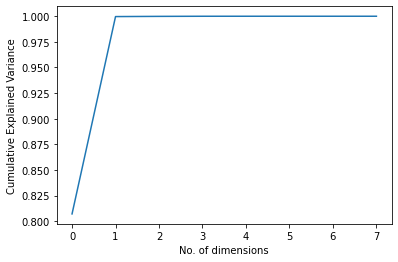

In [6]:
pca=PCA().fit(inputs)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('No. of dimensions')
plt.ylabel('Cumulative Explained Variance')

### PCA

We will now reduce the dimensionality of the data (both testing and training sets)

In [7]:
pca = PCA(1)  

inputsPCA = pca.fit_transform(inputs)

In [8]:
inputsPCA.shape

(768, 1)

### Plot Some Data

We need to scale this data using the [Min Max Scaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

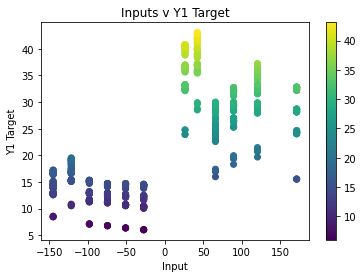

In [9]:
plt.figure()
plt.scatter(inputsPCA[:,0], targets[:,:1], c= targets[:,0])
plt.title("Inputs v Y1 Target")
plt.colorbar()
plt.xlabel('Input')
plt.ylabel('Y1 Target')
plt.show()

In [10]:
scaler = MinMaxScaler()

inputsScaled = scaler.fit_transform(inputsPCA)
inputsScaledNoPCA = scaler.fit_transform(inputs)

targetsScaled = scaler.fit_transform(targets)

targetsScaled_y1 = scaler.fit_transform(targets_y1)
targetsScaled_y2 = scaler.fit_transform(targets_y2)

We can now see that the data has been scalled so the minimum input/target value is now 0 and the maximum input/target value is 1.

This reduction in the range of the data makes it much easier for the models to train, having the effect of making them much more accurate. However, for some data it isnt practical to scale the target values.

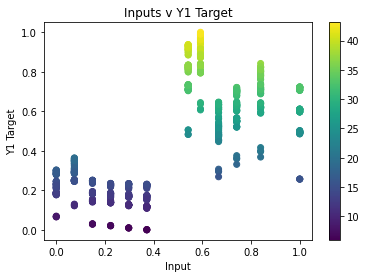

In [11]:
plt.figure()
plt.scatter(inputsScaled[:,0], targetsScaled[:,:1], c= targets[:,0])
plt.title("Inputs v Y1 Target")
plt.colorbar()
plt.xlabel('Input')
plt.ylabel('Y1 Target')
plt.show()

## Random Forest

In [12]:
rf = RandomForestRegressor()
rfCvPca = cross_validate(rf, inputsScaled, targetsScaled, cv=25, return_train_score=True, 
                         scoring='neg_mean_squared_error')

In [13]:
rf = RandomForestRegressor()
rfCvNoPca = cross_validate(rf, inputsScaledNoPCA, targetsScaled, cv=25, return_train_score=True, 
                           scoring='neg_mean_squared_error')

In [14]:
rfResultsTrain = {"RF w/ PCA - Test Score": rfCvPca['test_score'], 
                  "RF w/o PCA - Test Score": rfCvNoPca['test_score']}

rfResultsTest = {"RF w/ PCA - Train Score": rfCvPca['train_score'],
                 "RF w/o PCA - Train Score": rfCvNoPca['train_score']}

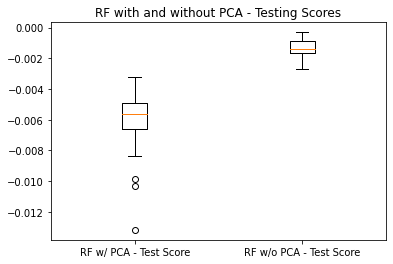

In [15]:
fig, ax = plt.subplots()
plt.title("RF with and without PCA - Testing Scores")
ax.boxplot(rfResultsTrain.values())
ax.set_xticklabels(rfResultsTrain.keys())
plt.show()

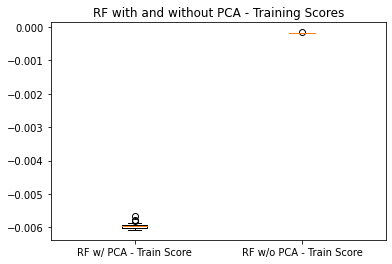

In [16]:
fig, ax = plt.subplots()
plt.title("RF with and without PCA - Training Scores")
ax.boxplot(rfResultsTest.values())
ax.set_xticklabels(rfResultsTest.keys())
plt.show()

### Random Forest Results

The random forset produced some unusual results, it performed much better on the data that had not undergone PCA compared to the data which was reduced down to 1 dimension. 

The non-reduced dataset has a much lower average error on the test data, -0.001 compared to -0.0065 for the reduced dataset. It also had a significantly smaller IQR compared to the reduced dataset.

## Neural Network

In [17]:
regressor = MLPRegressor(max_iter=15000)
nnCvPca = cross_validate(regressor, inputsScaled, targetsScaled, cv=25, return_train_score=True, 
                         scoring='neg_mean_squared_error')

In [18]:
regressor = MLPRegressor(max_iter=15000)
nnCvNoPca = cross_validate(regressor, inputsScaledNoPCA, targetsScaled, cv=25, return_train_score=True, 
                           scoring='neg_mean_squared_error')

In [19]:
nnResultsTrain = {"NN w/ PCA - Test Score": nnCvPca['test_score'], 
                  "NN w/o PCA - Test Score": nnCvNoPca['test_score']}

nnResultsTest = {"NN w/ PCA - Train Score": nnCvPca['train_score'],
                  "NN w/o PCA - Train Score": nnCvNoPca['train_score']}

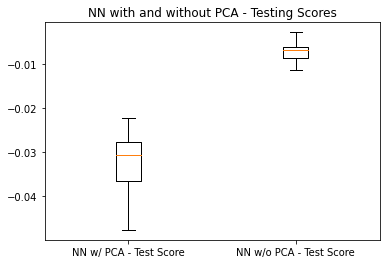

In [20]:
fig, ax = plt.subplots()
plt.title("NN with and without PCA - Testing Scores")
ax.boxplot(nnResultsTrain.values())
ax.set_xticklabels(nnResultsTrain.keys())
plt.show()

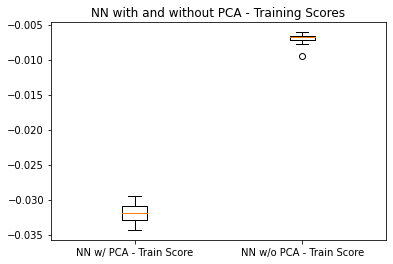

In [21]:
fig, ax = plt.subplots()
plt.title("NN with and without PCA - Training Scores")
ax.boxplot(nnResultsTest.values())
ax.set_xticklabels(nnResultsTest.keys())
plt.show()

### Neural Network Results

The neural network also produced some unusual results, again performing much better on the data that had not undergone PCA compared to the data which was reduced down to 1 dimension. 

The non-reduced dataset has a much lower average error on the test data, -0.005 compared to -0.03 for the reduced dataset. It also had a significantly smaller IQR compared to the reduced dataset.

## Support Vector Machine

The SVM can only predict a single output variable, because our dataset has two output variables (Y1 and Y2) we need to train two seperate SVMs.

### Y1

In [22]:
svr = svm.SVR(gamma="auto")
svmCvPca_y1 = cross_validate(svr, inputsScaled, targetsScaled_y1.ravel(), cv=25, return_train_score=True, 
                           scoring='neg_mean_squared_error')

In [23]:
svr = svm.SVR(gamma="auto")
svmCvNoPca_y1 = cross_validate(svr, inputsScaledNoPCA, targetsScaled_y1.ravel(), cv=25, return_train_score=True, 
                           scoring='neg_mean_squared_error')

In [24]:
svmResultsTrain_y1 = {"SVM w/ PCA - Test Score": svmCvPca_y1['test_score'], 
                  "SVM w/o PCA - Test Score": svmCvNoPca_y1['test_score']}

svmResultsTest_y1 = {"SVM w/ PCA - Train Score": svmCvPca_y1['train_score'],
                  "SVM w/o PCA - Train Score": svmCvNoPca_y1['train_score']}

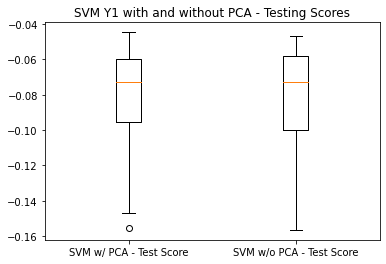

In [25]:
fig, ax = plt.subplots()
plt.title("SVM Y1 with and without PCA - Testing Scores")
ax.boxplot(svmResultsTrain_y1.values())
ax.set_xticklabels(svmResultsTrain_y1.keys())
plt.show()

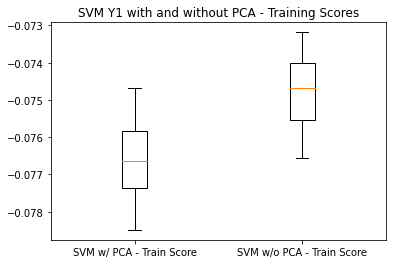

In [26]:
fig, ax = plt.subplots()
plt.title("SVM Y1 with and without PCA - Training Scores")
ax.boxplot(svmResultsTest_y1.values())
ax.set_xticklabels(svmResultsTest_y1.keys())
plt.show()

### Y2

In [27]:
svr = svm.SVR(gamma="auto")
svmCvPca_y2 = cross_validate(svr, inputsScaled, targetsScaled_y2.ravel(), cv=25, return_train_score=True, 
                           scoring='neg_mean_squared_error')

In [28]:
supportVectorMachine = svm.SVR(gamma="auto")
svmCvNoPca_y2 = cross_validate(svr, inputsScaledNoPCA, targetsScaled_y2.ravel(), cv=25, return_train_score=True, 
                           scoring='neg_mean_squared_error')

In [29]:
svmResultsTrain_y2 = {"SVM w/ PCA - Test Score": svmCvPca_y2['test_score'], 
                  "SVM w/o PCA - Test Score": svmCvNoPca_y2['test_score']}

svmResultsTest_y2 = {"SVM w/ PCA - Train Score": svmCvPca_y2['train_score'],
                  "SVM w/o PCA - Train Score": svmCvNoPca_y2['train_score']}

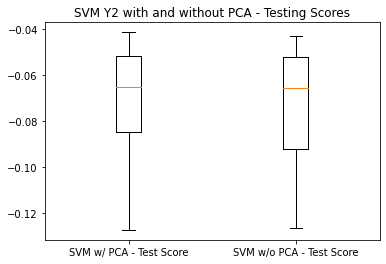

In [30]:
fig, ax = plt.subplots()
plt.title("SVM Y2 with and without PCA - Testing Scores")
ax.boxplot(svmResultsTrain_y2.values())
ax.set_xticklabels(svmResultsTrain_y2.keys())
plt.show()

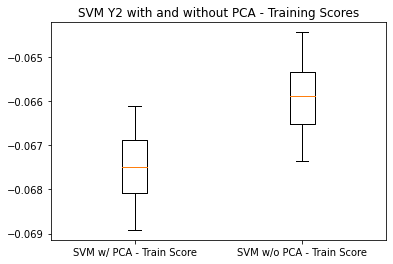

In [31]:
fig, ax = plt.subplots()
plt.title("SVM Y2 with and without PCA - Training Scores")
ax.boxplot(svmResultsTest_y2.values())
ax.set_xticklabels(svmResultsTest_y2.keys())
plt.show()

### Support Vector Machine Results

The support vector machine did not produce the same interesting results as seen with the random forest and neural network. With the average for Y1 and Y2 being approximatly -0.08 and -0.07 respectivly, with little difference between the reduced and non-reduced dataset.

Both had an IQR that was approximatly the same, again with little difference between the reduced and non reduced data.

## Predict a Value With Each Model

Bellow the code trains each model on all the data, and then outputs a predidicted value based off an example input.

Note, that as the input is scaled, you would need to relate the output onto a graph of the targets of training data to see how it fitted in relative to the original dataset.

In [75]:
scaler = MinMaxScaler()
scaler.fit(inputs)

test = [[0.5,658,300,150,3.5,4,0.1,2]]


testScaled = scaler.transform(test)

In [76]:
testScaled

array([[-0.33333333,  0.48809524,  0.32069971,  0.36054422,  0.        ,
         0.66666667,  0.25      ,  0.4       ]])

### Random Forest

In [77]:
rf = RandomForestRegressor()
rf.fit(inputsScaledNoPCA, targetsScaled)
rf.predict(testScaled)

array([[0.43570504, 0.33657959]])

### Neural Network

In [81]:
regressor = MLPRegressor(max_iter=15000)
regressor.fit(inputsScaledNoPCA, targetsScaled)
regressor.predict(testScaled)

array([[0.20475814, 0.26707499]])

### SVM

In [82]:
svrY1 = svm.SVR(gamma="auto")
svrY1.fit(inputsScaledNoPCA, targetsScaled_y1.ravel())
svrY1.predict(testScaled)

array([0.40727445])

In [83]:
svrY2 = svm.SVR(gamma="auto")
svrY1.fit(inputsScaledNoPCA, targetsScaled_y2.ravel())
svrY1.predict(testScaled)

array([0.34494246])

## Overall Results

In summary the random forest is the best choice, with performance more than an order of magnitude more accurate compared the the neural network. Along with this the training time was pretty similar to the neural network.

SVM is a clear third place however, with drastically worse average scores than the neural network and random forest.

## PCA Anomalies 

It's not competly clear why the classifieres all train poorly on the reduced dataset, regardless of the CEV graph showing that 1 dimension should represent all of the variance in the data. Presumably there is some element of the data that isn't well represented when scaled down using PCA. 

# Part 2 - Optimisation

Implement an optimiser to solve a timetabling problem for a university. A file has been provided that describes modules, and lists modules against which they cannot be scheduled. A module **consists of one lecture per week and one or more lab sessions**.

Optimise a timetable so that session is scheduled once per week in such a way that
timetable constraints are minimised. There are **20 sessions per week**. You have **one lecture theatre
and two labs available**.

Relevant constraints for this assessment are:

- A session cannot be scheduled for a time when any of its students or staff are in another session (concurrence constraints). The sessions for a module that clash are shown in the data file.
- A lab session cannot occur in the week before its corresponding lecture has taken place (precedence constraints).

You must design and implement a fitness function by taking the **number of the concurrence constraints and multiplying them with the number of precedence constraints**. This fitness function should be minimised – the ideal timetable is one with no constraint violations at all, in which case the function will return ~0~ 1. 

To note, as the fitness functions multiplies the constraints the best output is 1, this had to be changed as previously if either was constraint was 0, the fitness function would output 0 incorrectly.

## Task 2.1 – Generation of random solutions (10% of total mark)

The first task is to implement the fitness function. Your code should read the file provided and given
a timetable it should return the quality of the schedule in terms of the constraint violations, as described
above. The function should be called the fitness of a random solution printed out.

NOTE - I have assumed that a lecture can take place in a lab, but a lab cannot take place in a lecture theatre

## Task 2.2 – Algorithm implementation (25% of total mark)

Implement a hillclimber to optimise the problem implemented in Task 2.1.

The algorithm must have the following features:

- It should be possible to use one of two mutation operators – one (session replace) mutates a solution by placing a session into another slot in the timetable, and the other is a ruin-andrecreate operator (which generates a completely new solution at random).
- At each iteration your single parent solution should be used to generate a single child operator by using one of the mutation operators (either the swap or the ruin-and-recreate for the entire run of the algorithm).
- At the end of an iteration the algorithm should retain the parent or child that has the best fitness.
- At the end of an iteration the best (parent or child) solution’s fitness should be added to a list of the best fitnesses, which is returned along with the best solution at the end of the optimisation.

## Task 2.3 – Visualisation of results (15% of total mark)

Run the algorithm twice for 500 iterations – once for each mutation operator. Repeat this 30 times, so that you get 30 fitness lists for the swap operator and 30 fitness lists for the ruin-andrecreate operator. 

Plot the average, maximum and minimum fitness at each iteration for each operator, plot them on the same graph so that they can be compared. 

You should be able to see which optimiser is best – state which in the notebook, and say why.

### Import Required Librairies

In [32]:
import copy as copy
import random as random
import matplotlib.pyplot as plt

## Import the Modules

In [33]:
def makeModule(line):
    m = {"code": "",
         "lecturer":"",
         "labs":0,
         "noclash":[]
        }
    
    m["code"] = line[:6]
    
    lecture = line[7:]
    count = 7
    for c in lecture:
        if c == "|":
            break
        count = count + 1
    
    m["lecturer"] = line[7:count]
        
    m["labs"] = line[count+1:count+2]
    
    
    m["noclash"] = line[count+3:].split(",")
        
    
    
    
    
    return m

In [34]:
f = open('Modules.txt', 'r')
Lines = f.readlines()

modulesList = []
 
for line in Lines:
    m = makeModule(line.strip())
    modulesList.append(m)

Modules is an array of dictionaries that contain the code, lecture, number of labs and an array of modules it cannot clash with

In [35]:
modulesList

[{'code': 'MOD001',
  'lecturer': 'Zacharias Karstensen',
  'labs': '2',
  'noclash': ['MOD002',
   'MOD003',
   'MOD004',
   'MOD005',
   'MOD006',
   'MOD007',
   'MOD008',
   'MOD009',
   'MOD010',
   'MOD013']},
 {'code': 'MOD002',
  'lecturer': 'Dominykas Cleary',
  'labs': '2',
  'noclash': ['MOD001',
   'MOD003',
   'MOD004',
   'MOD005',
   'MOD006',
   'MOD007',
   'MOD008',
   'MOD009',
   'MOD010',
   'MOD013']},
 {'code': 'MOD003',
  'lecturer': 'Zacharias Karstensen',
  'labs': '2',
  'noclash': ['MOD001',
   'MOD002',
   'MOD004',
   'MOD005',
   'MOD006',
   'MOD007',
   'MOD008',
   'MOD009',
   'MOD010',
   'MOD011',
   'MOD012',
   'MOD013']},
 {'code': 'MOD004',
  'lecturer': 'Laila Deniau',
  'labs': '1',
  'noclash': ['MOD001',
   'MOD002',
   'MOD003',
   'MOD005',
   'MOD006',
   'MOD007',
   'MOD008',
   'MOD009',
   'MOD010',
   'MOD011',
   'MOD012',
   'MOD013']},
 {'code': 'MOD005',
  'lecturer': 'Brahma O Braonain',
  'labs': '2',
  'noclash': ['MOD001',
  

We now have the modules in a data structure that we can work with

We need to create another data structure that can represent the different labs and lecture rooms.

The blankWeek() function returns a empty week data structure.

In [36]:
def blankWeek():
    return [
    {
        "day": "Monday",
        "theatre": [None, None, None, None],
        "lab1": [None, None, None, None],
        "lab2": [None, None, None, None]
    },
    {
        "day": "Tuesday",
        "theatre": [None, None, None, None],
        "lab1": [None, None, None, None],
        "lab2": [None, None, None, None]
    },
    {
        "day": "Wednesday",
        "theatre": [None, None, None, None],
        "lab1": [None, None, None, None],
        "lab2": [None, None, None, None]
    },
    {
        "day": "Thursday",
        "theatre": [None, None, None, None],
        "lab1": [None, None, None, None],
        "lab2": [None, None, None, None]
    },
    {
        "day": "Friday",
        "theatre": [None, None, None, None],
        "lab1": [None, None, None, None],
        "lab2": [None, None, None, None]
    }
]

In [37]:
print(blankWeek())

[{'day': 'Monday', 'theatre': [None, None, None, None], 'lab1': [None, None, None, None], 'lab2': [None, None, None, None]}, {'day': 'Tuesday', 'theatre': [None, None, None, None], 'lab1': [None, None, None, None], 'lab2': [None, None, None, None]}, {'day': 'Wednesday', 'theatre': [None, None, None, None], 'lab1': [None, None, None, None], 'lab2': [None, None, None, None]}, {'day': 'Thursday', 'theatre': [None, None, None, None], 'lab1': [None, None, None, None], 'lab2': [None, None, None, None]}, {'day': 'Friday', 'theatre': [None, None, None, None], 'lab1': [None, None, None, None], 'lab2': [None, None, None, None]}]


The Week is an array of 5 dictionaries whcih contain keys for the day, and each of the rooms (lecture theatre, and the two labs). These have an array, which will then be populated by the module codes (but has a default of None for now)

## Generate a Random Solution

This function has to take in the array of all modules and the number of labs, and create a random solution.

It creates a random solution by selecting a random day and session (and room in the case of labs) and inserting a lecture/lab from the list.

One varibale here is if you allow lectures to happen in labs, I chose not to allow this as it would take lab space away from the actual labs (as they must happen in a lab), which also making calculating the fitness more computationly complex.

In [38]:
def randomSolution(modules):
    lectures = []
    labs = []
    
    newWeek = blankWeek()
    
    
    
    for d in modules:
        lectures.append(d["code"])
        for i in range(int(d["labs"])):
            labs.append(d["code"])    
    
    while len(lectures) > 0:
        module = lectures[0]
        
        day = random.randrange(0, 5)
        session = random.randrange(0,4)

        if newWeek[day]["theatre"][session] == None:
            newWeek[day]["theatre"][session] = module
            lectures.pop(0)
    
    while len(labs) > 0:
        module = labs[0]
        
        day = random.randrange(0, 5)
        room = random.randrange(0,2)
        session = random.randrange(0,4)
                
        if room == 0:
            if newWeek[day]["lab1"][session] == None:
                newWeek[day]["lab1"][session] = module
                labs.pop(0)
        elif room == 1:
            if newWeek[day]["lab2"][session] == None:
                newWeek[day]["lab2"][session] = module
                labs.pop(0)
        

    return newWeek

In [39]:
week = randomSolution(modulesList)

week

[{'day': 'Monday',
  'theatre': ['MOD017', None, 'MOD002', 'MOD001'],
  'lab1': ['MOD005', None, 'MOD005', None],
  'lab2': ['MOD014', 'MOD013', 'MOD015', 'MOD012']},
 {'day': 'Tuesday',
  'theatre': ['MOD010', 'MOD008', 'MOD012', 'MOD007'],
  'lab1': ['MOD014', 'MOD008', 'MOD007', 'MOD003'],
  'lab2': [None, 'MOD010', 'MOD012', 'MOD006']},
 {'day': 'Wednesday',
  'theatre': ['MOD006', 'MOD004', None, 'MOD005'],
  'lab1': ['MOD009', None, 'MOD009', None],
  'lab2': ['MOD004', 'MOD006', 'MOD002', 'MOD017']},
 {'day': 'Thursday',
  'theatre': ['MOD015', 'MOD009', 'MOD014', 'MOD003'],
  'lab1': ['MOD011', 'MOD015', 'MOD010', 'MOD001'],
  'lab2': ['MOD009', None, 'MOD002', 'MOD016']},
 {'day': 'Friday',
  'theatre': [None, 'MOD013', 'MOD016', 'MOD011'],
  'lab1': ['MOD008', 'MOD006', 'MOD003', 'MOD001'],
  'lab2': ['MOD011', None, None, None]}]

### Fitness Function

This function takes the week and outputs a value of fitness for the week

In [40]:
def room(number):
    if number == 0:
        return "theatre"
    elif number == 1:
        return "lab1"
    elif number == 2:
        return "lab2"

def moduleNoClash(module, modules):
    for m in modules:
        if m["code"] == module:
            return m["noclash"]

def fitness(wk):
    cC = 1 #number of concurence constrain violations
    pC = 1 #number of precendece constrain violations
    
    weekToFitness = copy.deepcopy(wk)
    
    # check concurence constraints
    for d in range(0,5):
        for r in range(0,3):
            for s in range(0,4):
                toCheck = moduleNoClash(weekToFitness[d][room(r)][s], modulesList)
                
                #if this slot has a module
                if(toCheck != None):
                    #check all the other rooms
                    #apart from the room the module currently being checked is in
                    
                    if(s != 0):
                        # check room leacture room
                        sessionModule = weekToFitness[d][room(0)][s]
                        for noClash in toCheck:
                            if noClash == sessionModule:
                                #add a concurence constraint violation
                                cC = cC + 1
                                
                    elif(s != 1):
                        # check room lab 1
                        sessionModule = weekToFitness[d][room(1)][s]
                        for noClash in toCheck:
                            if noClash == sessionModule:
                                #add a concurence constraint violation
                                cC = cC + 1
                                
                    elif(s != 2):
                        # check lab 2
                        sessionModule = weekToFitness[d][room(2)][s]
                        for noClash in toCheck:
                            if noClash == sessionModule:
                                #add a concurence constraint violation
                                cC = cC + 1
    
    # check precedence violation
    # loop through all the lectures
    for d1 in range(0,5):
        for s1 in range(0,4):
            lectureCode = weekToFitness[d1][room(0)][s1]
            
            #search through all labs that happen before the lecture
            for d2 in range(0,d1):
                for r in range(1,3):
                    for s2 in range(0,4):
                        if(s2 > s1 and d2 == d1):
                            # if this is true, then we are checking a session that is on the same day
                            # but after the lecture, these are valid so do not need to be checked
                            # so just break out of the loop
                            break
                        else:
                            if(lectureCode == weekToFitness[d2][room(r)][s2]):
                                pC = pC + 1
            
                            
            
    
    return cC * pC

                        

In [41]:
fitness(week)

276

### Mutation Function

This function takes in a week and a mutation type, it then performs the desired mutation on the week

In [42]:
def mutate(wk, mutationType):
    
    weekToMutate = copy.deepcopy(wk)
    
    if(mutationType == "sr"):
        # session replacement
        # choose a random session
        
        # two random sessions
        # the first shall not be empty, the second can be empty
        
        moduleA = None
        while moduleA == None:
            dayA = random.randrange(0, 5)
            roomA = random.randrange(0,3)
            sessionA = random.randrange(0,4)
            moduleA = weekToMutate[dayA][room(roomA)][sessionA]      
        
        dayB = random.randrange(0, 5)
        roomB = random.randrange(0,3)
        sessionB = random.randrange(0,4)
        
        moduleB = weekToMutate[dayB][room(roomB)][sessionB]
        
        # swap
        weekToMutate[dayA][room(roomA)][sessionA] = moduleB
        weekToMutate[dayB][room(roomB)][sessionB] = moduleA
         
        return weekToMutate
        
    elif(mutationType == "rr"):
        # ruin and recreate
    
        return randomSolution(modulesList)
    
    else:
        print("Mutation type not valid")
        return blankWeek()
    

In [43]:
fitness(mutate(week,"sr"))

322

### Hill Climber

The hill climber performs a number of mutations of a certain type on a randomSolution. It then outputs the bestWeek and an array of the fitness at the end of each iteration.

In [44]:
import copy

def hillclimber(mutationType, iterations):
    fitnesses = []
    
    parent = randomSolution(modulesList)
    parentFitness = fitness(parent)
    
    for i in range(iterations): 
        child = copy.deepcopy(mutate(parent, mutationType))
        childFitness = fitness(child)
        
        if childFitness < parentFitness:
            parentFitness = childFitness
            parent = child
            
        fitnesses.append(parentFitness)

    return fitnesses, parent

In [45]:
fitnesses, bestWeek = hillclimber("sr", 500)

In [46]:
bestWeek

[{'day': 'Monday',
  'theatre': [None, 'MOD013', 'MOD016', None],
  'lab1': ['MOD011', 'MOD014', 'MOD010', 'MOD002'],
  'lab2': ['MOD010', 'MOD007', 'MOD002', 'MOD011']},
 {'day': 'Tuesday',
  'theatre': ['MOD009', 'MOD003', 'MOD001', 'MOD005'],
  'lab1': ['MOD003', 'MOD003', 'MOD001', 'MOD014'],
  'lab2': ['MOD017', 'MOD014', 'MOD011', 'MOD013']},
 {'day': 'Wednesday',
  'theatre': ['MOD012', 'MOD006', None, 'MOD004'],
  'lab1': [None, 'MOD006', 'MOD010', None],
  'lab2': [None, 'MOD015', 'MOD006', None]},
 {'day': 'Thursday',
  'theatre': ['MOD009', 'MOD005', 'MOD008', 'MOD016'],
  'lab1': ['MOD015', None, 'MOD002', 'MOD012'],
  'lab2': ['MOD001', None, None, 'MOD006']},
 {'day': 'Friday',
  'theatre': ['MOD008', 'MOD008', 'MOD009', 'MOD004'],
  'lab1': [None, None, 'MOD009', 'MOD017'],
  'lab2': ['MOD005', 'MOD007', 'MOD015', 'MOD012']}]

In [47]:
fitness(bestWeek)

4

### Repeate 30 times for each mutation type, calculate max, min and avg

In [48]:
bestFitnessSr = []
bestFitnessRr = []

bestWeekSr = []
bestWeekRr = []

resultsSr = []
resultsRr = []

for i in range (30):
    bestFitnessSrOutput, bestWeekSrOutput = hillclimber("sr", 500)
    bestFitnessSr.append(bestFitnessSrOutput)
    bestWeekSr.append(bestWeekSrOutput)
    
    bestFitnessRrOutput, bestWeekRrOutput = hillclimber("rr", 500)
    bestFitnessRr.append(bestFitnessRrOutput)
    bestWeekRr.append(bestWeekRrOutput)
    
    resultsSr.append([max(bestFitnessSr[i]), sum(bestFitnessSr[i])/len(bestFitnessSr[i]), min(bestFitnessSr[i])])
    resultsRr.append([max(bestFitnessRr[i]),  sum(bestFitnessRr[i])/len(bestFitnessRr[i]), min(bestFitnessRr[i])])
    

### Graphs

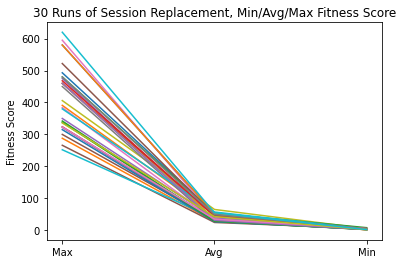

In [49]:
for r in resultsSr:
    plt.plot(["Max","Avg","Min"], r)
    
plt.title('30 Runs of Session Replacement, Min/Avg/Max Fitness Score')
plt.ylabel('Fitness Score')
plt.show()

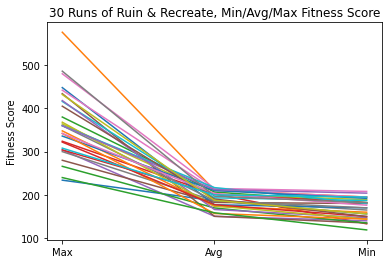

In [50]:
for r in resultsRr:
    plt.plot(["Max","Avg","Min"], r)
    
plt.title('30 Runs of Ruin & Recreate, Min/Avg/Max Fitness Score')
plt.ylabel('Fitness Score')
plt.show()

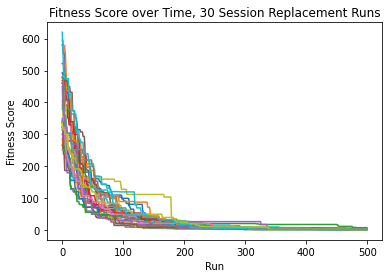

In [51]:
for r in bestFitnessSr:
    plt.plot(r)
    
plt.title('Fitness Score over Time, 30 Session Replacement Runs')
plt.ylabel('Fitness Score')
plt.xlabel('Run')
plt.show()

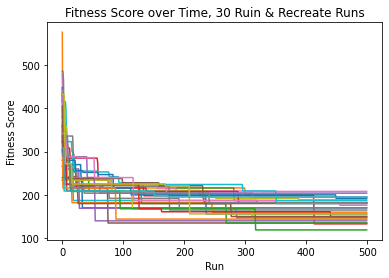

In [52]:
for r in bestFitnessRr:
    plt.plot(r)
    
plt.title('Fitness Score over Time, 30 Ruin & Recreate Runs')
plt.ylabel('Fitness Score')
plt.xlabel('Run')
plt.show()

## Comparision Graphs

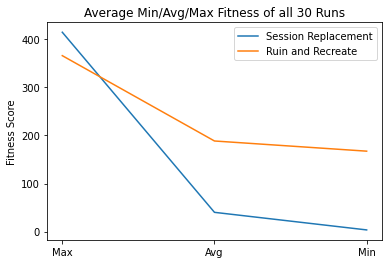

In [53]:
avgMinSr = 0
avgAvgSr = 0
avgMaxSr = 0
cSr = 0

for r in resultsSr:
    cSr = cSr + 1
    avgMinSr = avgMinSr + r[0]
    avgAvgSr = avgAvgSr + r[1]
    avgMaxSr = avgMaxSr + r[2]

plt.plot(["Max","Avg","Min"], [avgMinSr/cSr, avgAvgSr/cSr, avgMaxSr/cSr], label="Session Replacement")

avgMinRr = 0
avgAvgRr = 0
avgMaxRr = 0
cRr = 0

for r in resultsRr:
    cRr = cRr + 1
    avgMinRr = avgMinRr + r[0]
    avgAvgRr = avgAvgRr + r[1]
    avgMaxRr = avgMaxRr + r[2]

plt.plot(["Max","Avg","Min"], [avgMinRr/cRr, avgAvgRr/cRr, avgMaxRr/cRr], label="Ruin and Recreate")

plt.legend(loc="upper right")
plt.title('Average Min/Avg/Max Fitness of all 30 Runs')
plt.ylabel('Fitness Score')
plt.show()

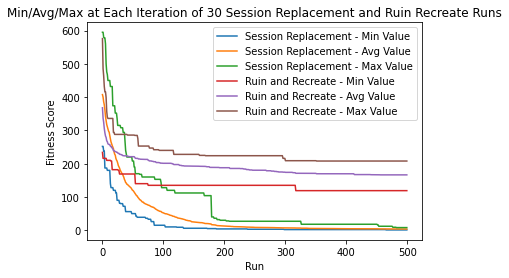

In [54]:
minFitnessAtIteration = []
avgFitnessAtIteration = []
maxFitnessAtIteration = []


for r in range(0,500):
    min = 0
    max = 0
    avg = 0
    iterationFitness = []
    
    for i in range(0,len(bestFitnessSr)-1):        
        iterationFitness.append(bestFitnessSr[i][r])

    
    results_list = sorted(iterationFitness)
    minFitnessAtIteration.append(results_list[0])
    avgFitnessAtIteration.append(sum(iterationFitness)/len(iterationFitness))
    maxFitnessAtIteration.append(results_list[-1])


plt.plot(minFitnessAtIteration, label="Session Replacement - Min Value")
plt.plot(avgFitnessAtIteration, label="Session Replacement - Avg Value")
plt.plot(maxFitnessAtIteration, label="Session Replacement - Max Value")

minFitnessAtIteration = []
avgFitnessAtIteration = []
maxFitnessAtIteration = []


for r in range(0,500):
    min = 0
    max = 0
    avg = 0
    iterationFitness = []
    
    for i in range(0,len(bestFitnessRr)-1):        
        iterationFitness.append(bestFitnessRr[i][r])

    
    results_list = sorted(iterationFitness)
    minFitnessAtIteration.append(results_list[0])
    avgFitnessAtIteration.append(sum(iterationFitness)/len(iterationFitness))
    maxFitnessAtIteration.append(results_list[-1])

plt.plot(minFitnessAtIteration, label="Ruin and Recreate - Min Value")
plt.plot(avgFitnessAtIteration, label="Ruin and Recreate - Avg Value")
plt.plot(maxFitnessAtIteration, label="Ruin and Recreate - Max Value")
    
plt.title('Min/Avg/Max at Each Iteration of 30 Session Replacement and Ruin Recreate Runs')
plt.legend(loc="upper right")
plt.ylabel('Fitness Score')
plt.xlabel('Run')
plt.show()

## Algorithm Efficacy

As you can see from the above graphs the session replacement performs significantly better than the ruin and recreate. Session repacement having a best fitnesses that were oftern in the low to mid single digits wherewas ruin and recreate had final best fits that averaged around 200. 

Initially however, ruin and recreate got better quick, it only took a handful of runs to get down from a fitness of around 500 to a fitness of 350, whereas ruin and recreate took closer to 20-40 runs to reach the same fitness value. This is not unexpected behaviour as to reduce the fitness by 150 points a lot of changes to the timetable would have to be made, which is not possible in such a small number of session replacements, but is possible when you generate new random solutions at the start of each iteration.